In [1]:
#Importing libraries
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from PIL import Image
import os
import shutil
import random
import torch
import torchvision
# Sets the seed for generating random numbers
torch.manual_seed(0)

# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'dataset'
source_dirs = ['normal', 'viral', 'COVID']

# create test directory
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
     os.mkdir(os.path.join(root_dir, 'test'))

     for i, d in enumerate(source_dirs):
         os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

     for c in class_names:
         os.mkdir(os.path.join(root_dir, 'test', c))

     for c in class_names:
         images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
         selected_images = random.sample(images, 30)
         for image in selected_images:
             source_path = os.path.join(root_dir, c, image)
             target_path = os.path.join(root_dir, 'test', c, image)
             shutil.move(source_path, target_path)

# Create Custom Dataset

In [3]:

class Dataset(torch.utils.data.Dataset):
    
    
    def __init__(self, img_dir, tr):
        
        def get_img(class_name):
            img = [x for x in os.listdir(img_dir[class_name]) if x[-3:].lower().endswith('png')]
            print(f'{len(img)} {class_name} samples')
            return img
        
        self.img = {}
        
        self.class_names = ['normal', 'viral', 'covid']
        
        #iterating over these classes to get images that belong to each
        for class_name in self.class_names:
            self.img[class_name] = get_img(class_name)
            
        self.img_dir = img_dir
        self.tr = tr
        
    
    def __len__(self):
        return sum([len(self.img[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        #to avoid out of bound index for each class
        index = index % len(self.img[class_name])
        image_name = self.img[class_name][index]
        image_path = os.path.join(self.img_dir[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.tr(image), self.class_names.index(class_name)

# Image Transformation

In [4]:
#data transformation for training set
train_transform = torchvision.transforms.Compose([
    #convert size of images
    torchvision.transforms.Resize(size=(224, 224)),
    #data augmentation by random horizontal flip
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #normalizing in the same range of pretrained Resnet-18 
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#data transformation for testing set
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoaders

In [5]:
train_dirs = {
    'normal': 'dataset/normal',
    'viral': 'dataset/viral',
    'covid': 'dataset/covid'
}

train_data = Dataset(train_dirs, train_transform)

10162 normal samples
1315 viral samples
3586 covid samples


In [6]:
test_dirs = {
    'normal': 'dataset/test/normal',
    'viral': 'dataset/test/viral',
    'covid': 'dataset/test/covid'
}

test_data = Dataset(test_dirs, test_transform)

30 normal samples
30 viral samples
30 covid samples


In [151]:
batch_size = 9

dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dataloader_train))
print('Number of test batches', len(dataloader_test))

Number of training batches 1674
Number of test batches 10


# Data Visualization

In [152]:

class_names = train_data.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(9, 5))
    for i, image in enumerate(images):
        plt.subplot(3, 3, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'lime'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

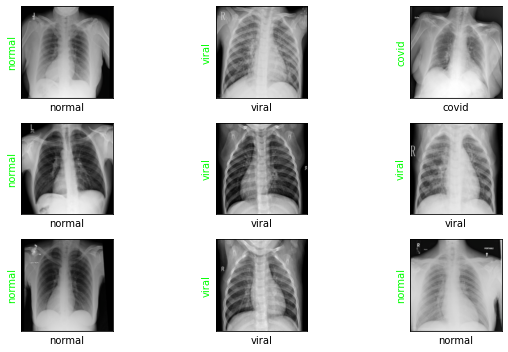

In [153]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

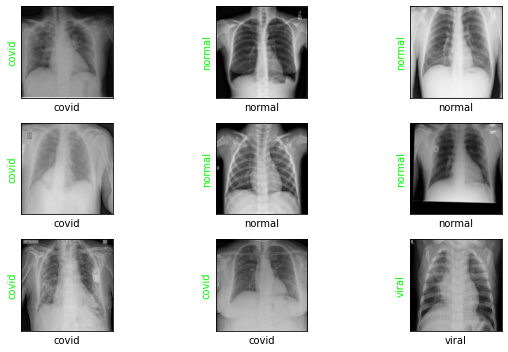

In [154]:
images, labels = next(iter(dataloader_test))
show_images(images, labels, labels)

# Creating the Model

In [155]:
#importing pretrained Resnet-18 model
resnet18 = torchvision.models.resnet18(pretrained=True)

# print(resnet18)

In [156]:
#adjusting Resnet-18 to our task by changing the last fully connected layer to 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
#define loss function
loss_fn = torch.nn.CrossEntropyLoss()
#define optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=2e-5)

In [157]:
#define function for prediction
def predictions():
    
    resnet18.eval()
    #iterate over test data
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images) 
    _, preds = torch.max(outputs, 1) #dimension 1 
    
    show_images(images, labels, preds) 

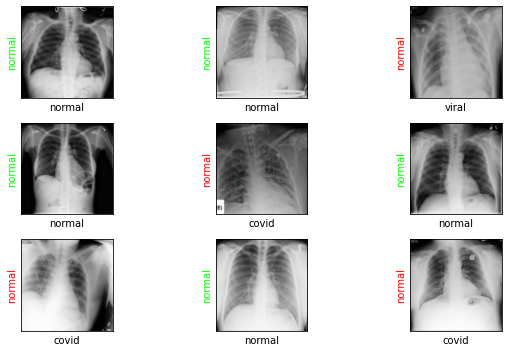

In [158]:
predictions()


# Training the Model

In [159]:
acc_ls=[]
loss_ls=[]
predict_ls=[]
actual_ls=[]

def train(epochs):

    for e in range(0, epochs):
        print(f'number of epochs {epochs}')

        train_loss = 0
        val_loss = 0

        resnet18.train()

        for train_step, (images, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 10 == 0:
                print('Step', train_step)

                accuracy = 0

                resnet18.eval() 
                
                for val_step, (images, labels) in enumerate(dataloader_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    y_t= np.asarray(preds, dtype=np.int64)
                    predict_ls.append(y_t)
                    y_act=np.asarray(labels, dtype=np.int64)
                    actual_ls.append(y_act)
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_data)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                acc_ls.append(accuracy)
                loss_ls.append(val_loss)

                show_preds()
                
                resnet18.train()
                
                if accuracy >= 0.96:
                    print('Performance condition satisfied')
                    return
        plt.plot(accuracy)
        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')


In [160]:
%%time

a=train(epochs=400)
print(a)

number of epochs 400
Step 0
Validation Loss: 1.3507, Accuracy: 0.3889
Step 10
Validation Loss: 1.2844, Accuracy: 0.4222
Step 20
Validation Loss: 1.0791, Accuracy: 0.5222
Step 30
Validation Loss: 0.8312, Accuracy: 0.6778
Step 40
Validation Loss: 0.7726, Accuracy: 0.7444
Step 50
Validation Loss: 0.5630, Accuracy: 0.8222
Step 60
Validation Loss: 0.4443, Accuracy: 0.8667
Step 70
Validation Loss: 0.4213, Accuracy: 0.8333
Step 80
Validation Loss: 0.3623, Accuracy: 0.9111
Step 90
Validation Loss: 0.3623, Accuracy: 0.9000
Step 100
Validation Loss: 0.3354, Accuracy: 0.9000
Step 110
Validation Loss: 0.3825, Accuracy: 0.8333
Step 120
Validation Loss: 0.2698, Accuracy: 0.9333
Step 130
Validation Loss: 0.3125, Accuracy: 0.8778
Step 140
Validation Loss: 0.3186, Accuracy: 0.8889
Step 150
Validation Loss: 0.3017, Accuracy: 0.9111
Step 160
Validation Loss: 0.3224, Accuracy: 0.8667
Step 170
Validation Loss: 0.2753, Accuracy: 0.9222
Step 180
Validation Loss: 0.1665, Accuracy: 0.9889
Performance condition

# Final Results

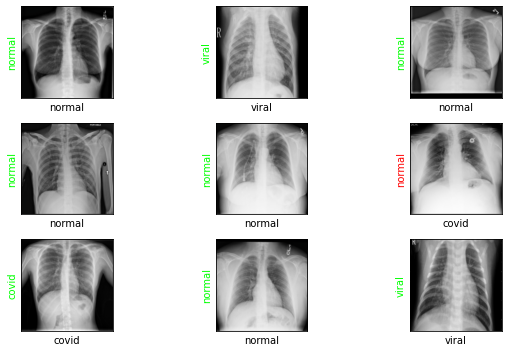

In [164]:
predictions()

Text(0, 0.5, 'Accuracy')

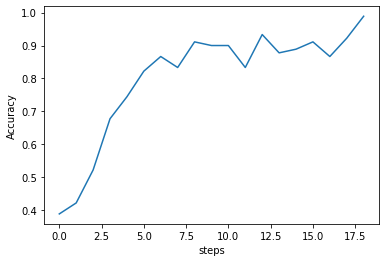

In [165]:

plt.plot(acc_ls)

plt.xlabel("steps")
plt.ylabel("Accuracy")

Text(0.5, 0, 'steps')

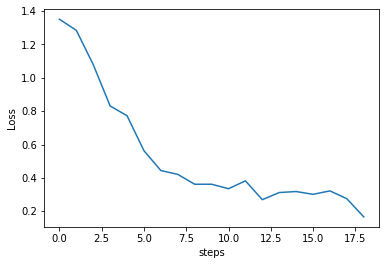

In [166]:
plt.plot(loss_ls)
plt.ylabel("Loss")
plt.xlabel("steps")

In [258]:
from sklearn.metrics import roc_curve
from sklearn.multiclass import MultiOutputMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

b=actual_ls[111]
c=predict_ls[111]

cm=confusion_matrix(b,c)

print(classification_report(b, c))
print(cm)





              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.89      0.92      0.89         9
weighted avg       0.93      0.89      0.89         9

[[2 0 0]
 [0 3 0]
 [1 0 3]]
